In [1]:
from __future__ import print_function, division

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from skimage import io
from PIL import Image

plt.ion()   # interactive mode

In [2]:
subset = 'train'
resized = 'resized2'

folder = ".."+os.sep+"data"+os.sep
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep

#Create mapping for labels
df = pd.read_csv(folder + file)
classes = df.classid.unique()
classes.sort()
classes_map = { classes[i]:i for i in range(len(classes)) }

In [3]:
# Dataset Class
class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes_map = classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 1]))
        image = io.imread(img_name + '.jpg')
        label = self.df.iloc[idx, 4]
        sample = {'image': image, 'label': classes_map[label]}

        if self.transform:
            sample['image'] = Image.fromarray(sample['image'])
            sample['image'] = self.transform(sample['image'])

        return sample

In [4]:
# Load Data
resized = 'resized2'
folder = ".."+os.sep+"data"+os.sep

transform = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Test Data
subset = 'validation'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : testset }
dataloaders = { 'train' : trainloader, 'val' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(testset) }

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

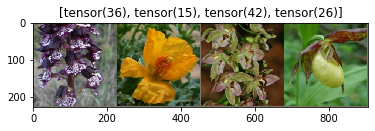

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataiter = iter(dataloaders['train'])
batch = dataiter.next()
images, labels = batch['image'], batch['label']  

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[x for x in labels])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data['image'].to(device), data['label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloaders['val']):
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format(preds[j],labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the network

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.5767 Acc: 0.3354
val Loss: 0.9130 Acc: 0.7281

Epoch 1/24
----------
train Loss: 1.1387 Acc: 0.6867
val Loss: 0.7078 Acc: 0.7885

Epoch 2/24
----------
train Loss: 0.6046 Acc: 0.8330
val Loss: 0.5826 Acc: 0.8129

Epoch 3/24
----------
train Loss: 0.3251 Acc: 0.9251
val Loss: 0.5374 Acc: 0.8403

Epoch 4/24
----------
train Loss: 0.2029 Acc: 0.9655
val Loss: 0.5807 Acc: 0.8360

Epoch 5/24
----------
train Loss: 0.1192 Acc: 0.9832
val Loss: 0.6388 Acc: 0.8288

Epoch 6/24
----------
train Loss: 0.1055 Acc: 0.9798
val Loss: 0.5370 Acc: 0.8403

Epoch 7/24
----------
train Loss: 0.0844 Acc: 0.9866
val Loss: 0.4937 Acc: 0.8619

Epoch 8/24
----------
train Loss: 0.0595 Acc: 0.9923
val Loss: 0.4695 Acc: 0.8763

Epoch 9/24
----------
train Loss: 0.0697 Acc: 0.9899
val Loss: 0.4688 Acc: 0.8619

Epoch 10/24
----------
train Loss: 0.0591 Acc: 0.9938
val Loss: 0.4738 Acc: 0.8691

Epoch 11/24
----------
train Loss: 0.0557 Acc: 0.9933
val Loss: 0.4733 Acc: 0.8633

Ep

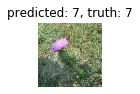

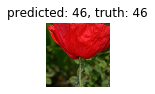

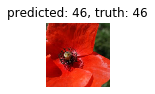

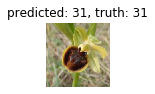

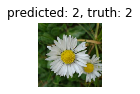

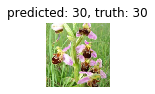

In [23]:
visualize_model(model_ft)

### Network as fixed feature extractor

In [24]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(classes))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.3331 Acc: 0.1895
val Loss: 1.9376 Acc: 0.5151

Epoch 1/24
----------
train Loss: 2.1728 Acc: 0.4626
val Loss: 1.3797 Acc: 0.6259

Epoch 2/24
----------
train Loss: 1.6658 Acc: 0.5888
val Loss: 1.0885 Acc: 0.7022

Epoch 3/24
----------
train Loss: 1.3911 Acc: 0.6425
val Loss: 0.9849 Acc: 0.7165

Epoch 4/24
----------
train Loss: 1.2981 Acc: 0.6713
val Loss: 0.9455 Acc: 0.7237

Epoch 5/24
----------
train Loss: 1.1651 Acc: 0.6934
val Loss: 0.9022 Acc: 0.7295

Epoch 6/24
----------
train Loss: 1.0663 Acc: 0.7150
val Loss: 0.8290 Acc: 0.7496

Epoch 7/24
----------
train Loss: 0.9228 Acc: 0.7855
val Loss: 0.7714 Acc: 0.7727

Epoch 8/24
----------
train Loss: 0.8876 Acc: 0.7970
val Loss: 0.7296 Acc: 0.7741

Epoch 9/24
----------
train Loss: 0.8803 Acc: 0.7913
val Loss: 0.7185 Acc: 0.7986

Epoch 10/24
----------
train Loss: 0.8731 Acc: 0.8023
val Loss: 0.7346 Acc: 0.7827

Epoch 11/24
----------
train Loss: 0.8766 Acc: 0.7985
val Loss: 0.7339 Acc: 0.7784

Ep

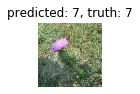

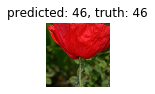

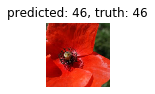

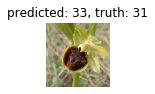

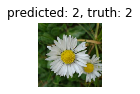

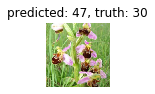

In [26]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Save the models !!!

In [31]:
# Save both Models
PATH = './model_conv.pth'
torch.save(model_conv.state_dict(), PATH)

PATH = './model_ft.pth'
torch.save(model_ft.state_dict(), PATH)

In [7]:
# Load Model FT
PATH = './model_ft.pth'
net = torchvision.models.resnet18()

# Adding the output layer
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 50)

# Load weights and send NN to device (GPU if available)
net.load_state_dict(torch.load(PATH))
net = net.to(device)

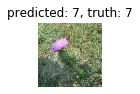

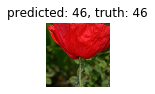

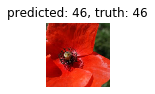

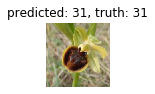

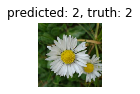

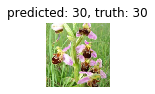

In [8]:
# Testing the model loads properly 
visualize_model(net)